## Eliminar Efecto de histéresis

Dalia Camacho

El propósito de esta tarea es modificar el MaxSelector para eliminar el efecto de histéresis. Primero definimos las funciones de la tarea pasada y el MaxSelector con el que al recibir dos estímulos se produce el efecto de histéresis.

In [1]:
# Importar librerías numpy y matplotlib.pyplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
# Se define una función escalón. 
# Elige entre dos valores, la elección depende de un threshhold
def step(pot, thr, val_less, val_gr_eq):
    return np.where(pot<thr,val_less,val_gr_eq)

# Se define una función que elige al valor de input si este es mayor o igual a cero. 
# Elige cero en otro caso
def ramp(pot, thr):
    return np.where(pot<thr, 0, pot)

# Se define una función que dadas ini, tau, f y delta realiza un paso del método de Euler
# Tau es una constante del sistema
def diff(ini,delta, tau, f):
    return ini+delta*f/tau

In [3]:
def plot_est_mem_out_H(n, vals1, vals2, matvals, vals3):
    fig = plt.figure()
    m   = np.shape(matvals)[1]
    for i in range(0,n):
        axi1 = fig.add_axes([0.0, 0.4*(n-i), 0.8, 0.4],
                   xticklabels=[], ylim=(0.0, 1.0), yticklabels=[])
        axi2 = fig.add_axes([0.9, 0.4*(n-i), 0.8, 0.4],
                   xticklabels=[], ylim=(0.0, 1.0), yticklabels=[])
        
        axj = fig.add_axes([1.8, 0.4*(n-i), 0.8, 0.4],
                   xticklabels=[], ylim=(-2.0, 2.0))
        
        axk = fig.add_axes([2.7, 0.4*(n-i), 0.8, 0.4],
                   xticklabels=[], ylim=(0.0, 1.0), yticklabels=[])
        
        axi1.add_patch(
        patches.Rectangle((0.5-vals1[i]/2, 0.5-vals1[i]/2), vals1[i], vals1[i]))
        
        axi2.add_patch(
        patches.Rectangle((0.5-(vals1[i]+vals2[i])/2, 0.5-(vals1[i]+vals2[i])/2),
                          (vals1[i]+vals2[i]), (vals1[i]+vals2[i])))
        
        axj.plot(matvals[i,])
        axj.plot(np.zeros(m))
        
        axk.add_patch(
        patches.Rectangle((0,0), vals3[i], vals3[i]))

In [4]:
# Definir parámetros del sistema a excepción del estímulo
time  = 10
delta = 0.05

tau_u = 1.0
w1_u  = 1.0
w2_u  = 1.0
h1_u  = 0.2
k_u   = 0.3

tau_v = 1.0
h2_v  = 0.5

In [5]:
def MaxSelectorH(time, delta, stimulus, stimulus2, lag, tau_u, w1_u, w2_u, h1_u, k_u, tau_v, h2_v):
    size  = np.size(stimulus)
    up    = np.zeros((size,1))
    uf    = np.zeros((size,1))
    sel   = np.zeros((size,1))
    matup = np.zeros((size,round(1/delta*time)))
    vp    = 0.0
    vf    = 0.0
    count = 0

    for t in np.arange(0.0, time, delta):
        if(t<lag):
            up  = diff(up, delta, tau_u, -up +w1_u*uf -w2_u*vf -h1_u +stimulus)
            uf  = step(up, k_u, 0.0, 1.0)
            matup[:,count] = up.T
            count          = count + 1
        
        else:
            up  = diff(up, delta, tau_u, -up +w1_u*uf -w2_u*vf -h1_u +stimulus+stimulus2)
            uf  = step(up, k_u, 0.0, 1.0)
            matup[:,count] = up.T
            count          = count + 1
        
            
        if (np.sum(uf) == 1 ):
            sel= uf
        else:
            sel = np.zeros((size,1))
    
        vp = diff(vp, delta, tau_v, -vp + np.sum(uf) -h2_v)
        vf = ramp(vp, 0.0)
        
    plot_est_mem_out_H(size, stimulus,stimulus2, matup ,uf)


    return(sel.T)



Corremos un ejemplo para mostrar el efecto de histéresis.

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

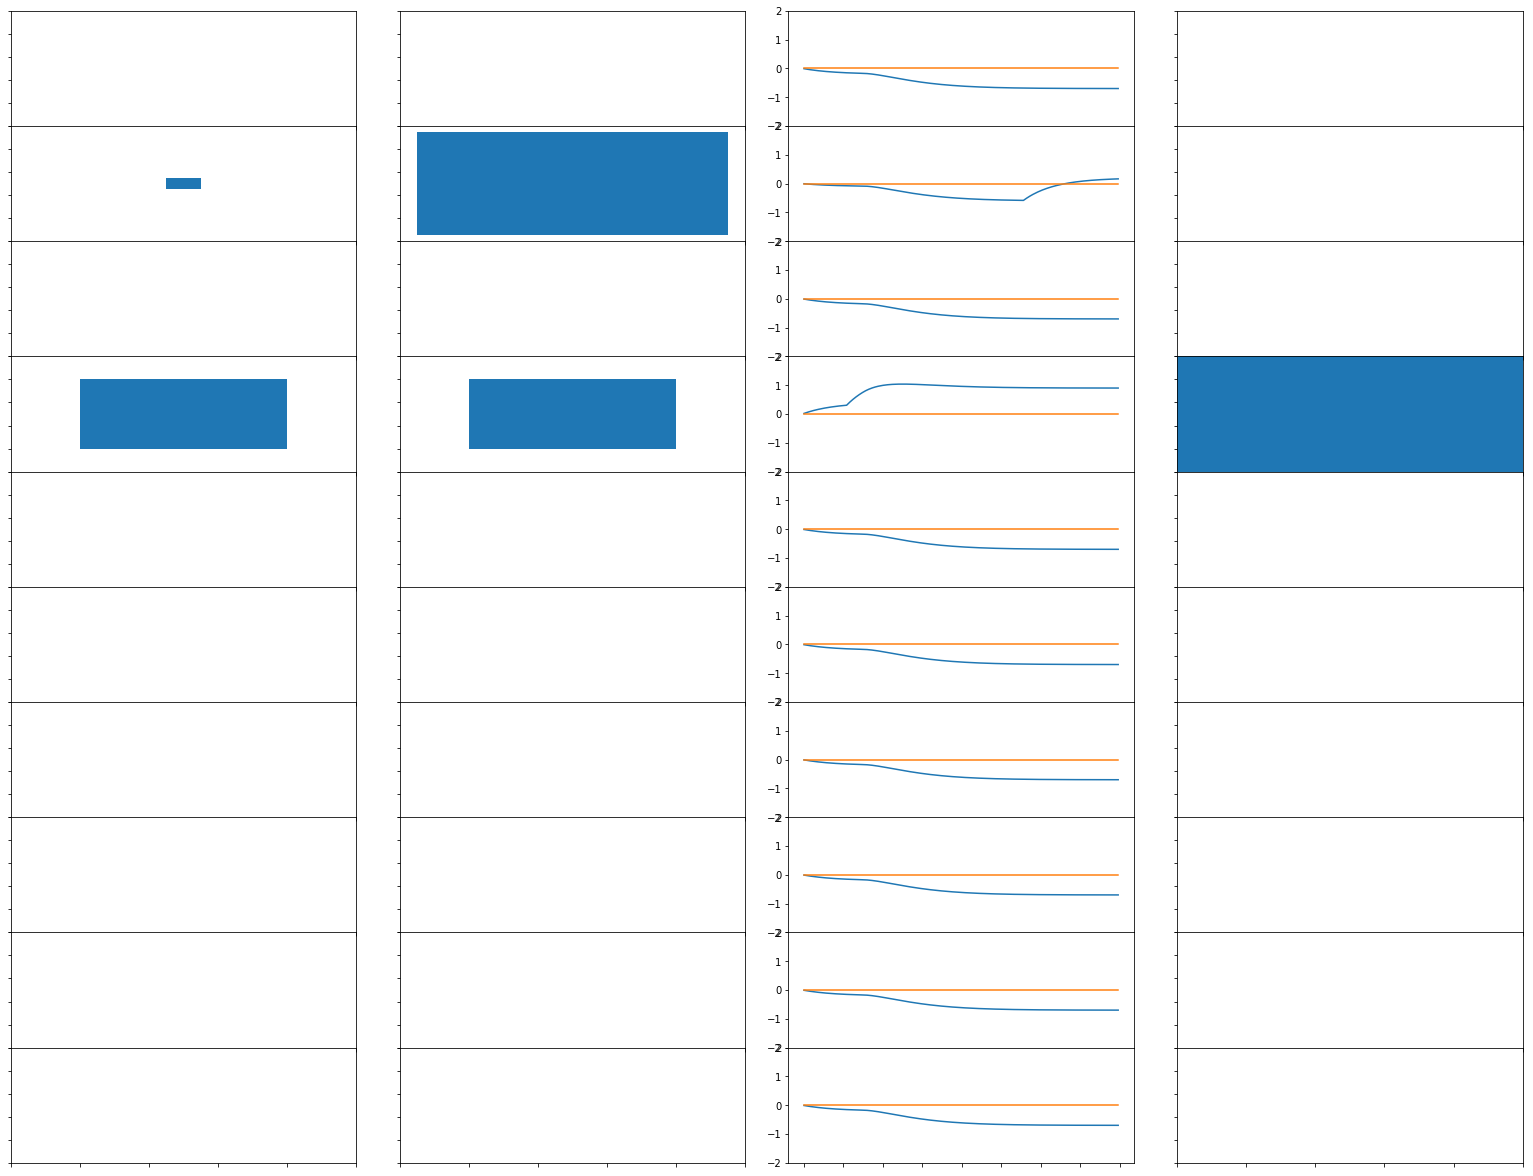

In [6]:
# El estímulo de la cuarta entrada es mayor en el estímulo inicial
# Con el segundo estímulo la suma de estímulos en la segunda entrada es mayor
stimulus  = np.array([[0.0, 0.1, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
stimulus2 = np.array([[0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
lag       = 7.0
MaxSelectorH(time, delta, stimulus, stimulus2, lag, tau_u, w1_u, w2_u, h1_u, k_u, tau_v, h2_v )

Ahora hacemos un MaxSelector en el que no se presenta el fenómeno de histéresis. Para lograr esto se puede disminuir la memoria en la neurona $v$. Como el cambio en el valor de $v$ depende del valor de $v$, modificamos la ecuación diferencial de $v$ a: $\tau_v \frac{\partial v}{\partial t}=-0.1v + w_n\sum_{i=1}^n f(u_i)-h_2.$ De esta forma el cambio de $v$ aún depende de $v$ pero en menor medida.

In [7]:
def MaxSelector_elimH(time, delta, stimulus, stimulus2, lag, tau_u, w1_u, w2_u, h1_u, k_u, tau_v, h2_v):
    size  = np.size(stimulus)
    up    = np.zeros((size,1))
    uf    = np.zeros((size,1))
    sel   = np.zeros((size,1))
    matup = np.zeros((size,round(1/delta*time)))
    vp    = 0.0
    vf    = 0.0
    count = 0

    for t in np.arange(0.0, time, delta):
        if(t<lag):
            up  = diff(up, delta, tau_u, -up +w1_u*uf -w2_u*vf -h1_u +stimulus)
            uf  = step(up, k_u, 0.0, 1.0)
            matup[:,count] = up.T
            count          = count + 1
        
        else:
            up  = diff(up, delta, tau_u, -up +w1_u*uf -w2_u*vf -h1_u +stimulus+stimulus2)
            uf  = step(up, k_u, 0.0, 1.0)
            matup[:,count] = up.T
            count          = count + 1
        
            
        if (np.sum(uf) == 1 ):
            sel= uf
        else:
            sel = np.zeros((size,1))
    
        vp = diff(vp, delta, tau_v, -vp*0.1 + np.sum(uf) -h2_v)
        vf = ramp(vp, 0.0)
        
    plot_est_mem_out_H(size, stimulus,stimulus2, matup ,uf)


    return(sel.T)



Repetimos el ejemplo anterior para mostrar que se elimina el efecto de histéresis. 

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

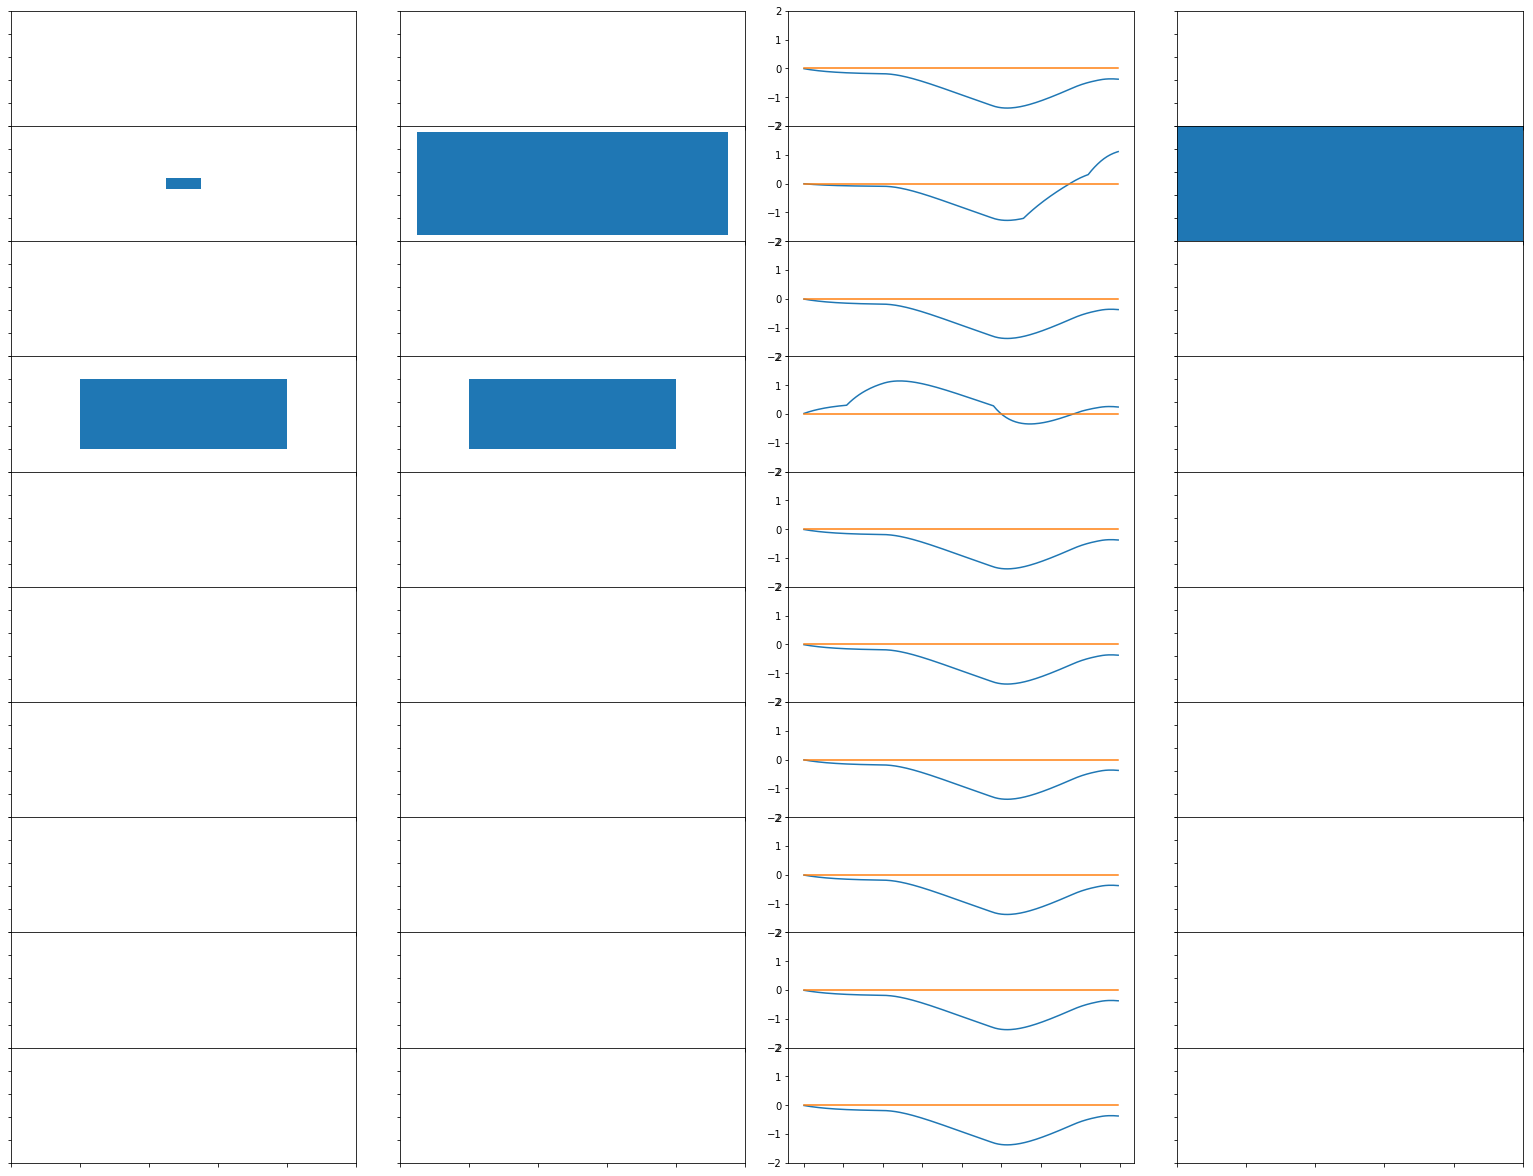

In [8]:
# Repetimos el ejemplo anterior
stimulus  = np.array([[0.0, 0.1, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
stimulus2 = np.array([[0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
lag       = 7.0
MaxSelector_elimH(time, delta, stimulus, stimulus2, lag, tau_u, w1_u, w2_u, h1_u, k_u, tau_v, h2_v )

Ahora hacemos otro ejemplo en el que el segundo estímulo es nulo para verificar que continúa eligiendo el máximo cuando no hay un segundo estímulo.  

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

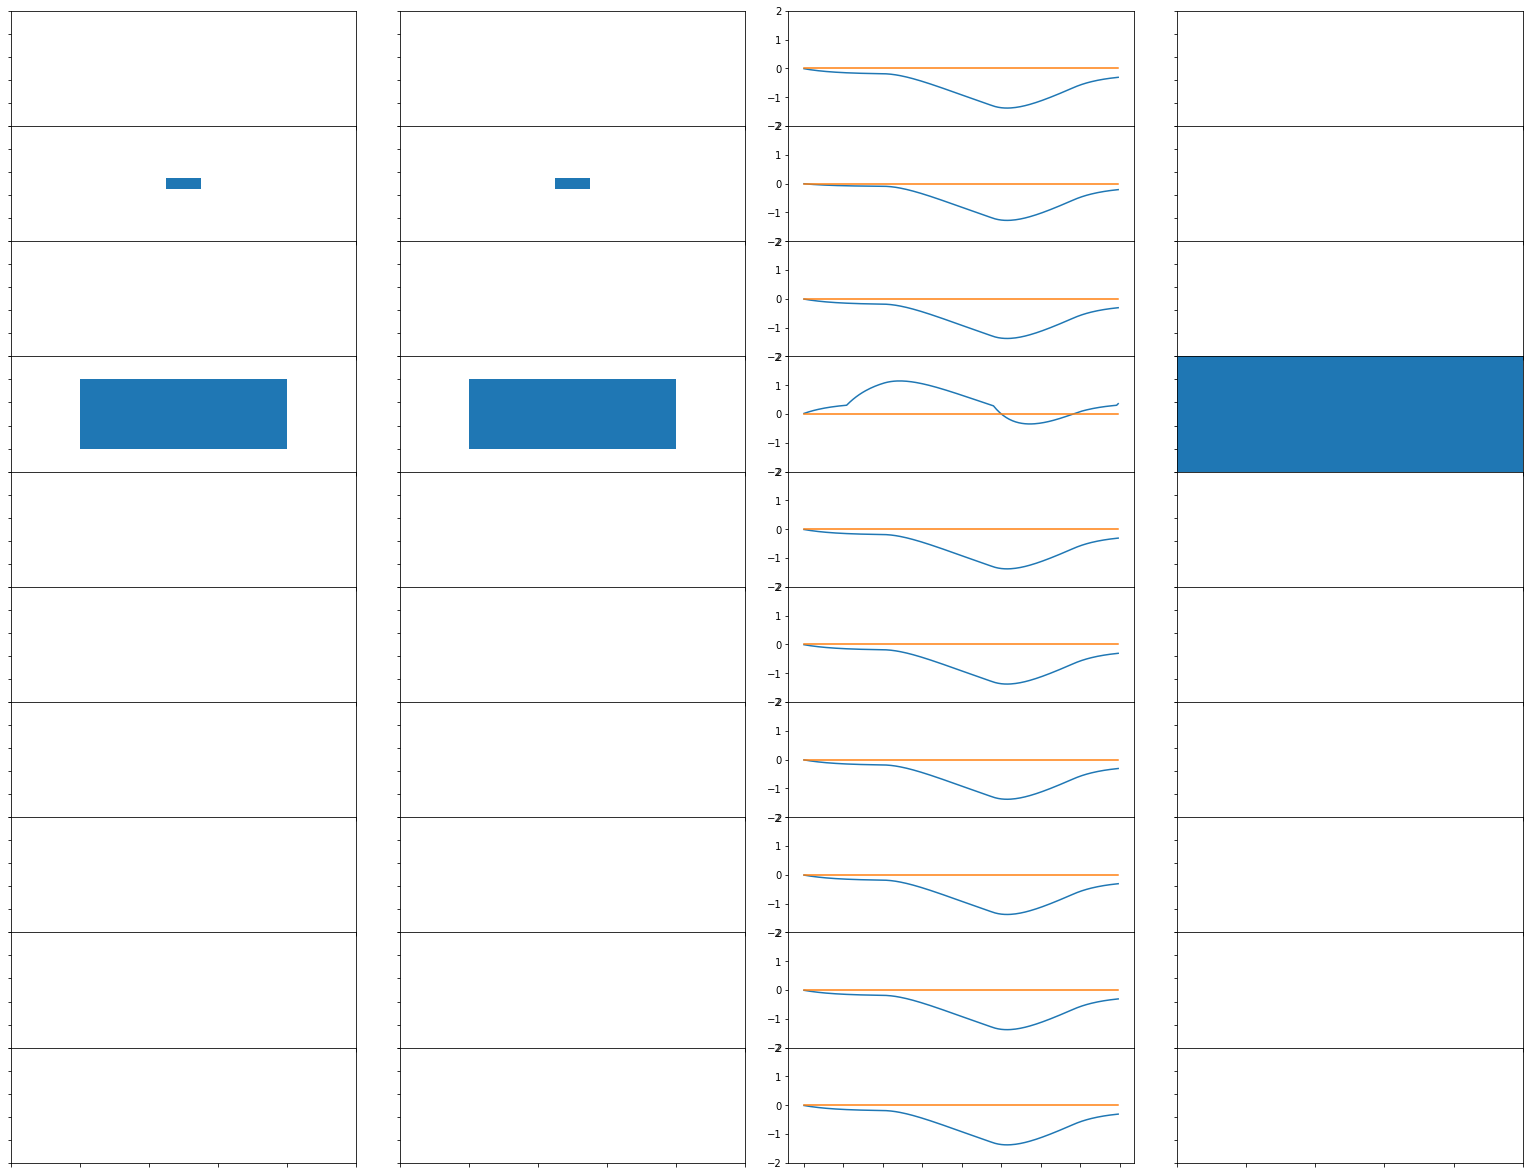

In [9]:
stimulus  = np.array([[0.0, 0.1, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
stimulus2 = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
lag       = 7.0
MaxSelector_elimH(time, delta, stimulus, stimulus2, lag, tau_u, w1_u, w2_u, h1_u, k_u, tau_v, h2_v )

In [103]:
def f1(vec):
    return np.where(vec<=0,0.0,1.0)

def f2(vec):
    return np.where(vec<=0,0,vec)


def f3(vec):
    n     = np.size(vec)
    sol   = np.zeros((n,1)) 
    f1vec = f1(vec)
    f2vec = f2(vec)
    for i in range(0,(n)):
        sol[i] = f2vec[i] -(np.sum(f2vec)-f2vec[i])/(np.sum(f1vec)-f1vec[i])
    return sol

def f4(vec):
    if(np.sum(f1(vec))==1):
        sol = 0
    else:
        sol = -np.sum(f1(vec))/np.size(vec)
    return sol

    
def MaxSelector3capas(stimulus, time, delta):
    n  = np.size(stimulus)
    v  = np.zeros((n,1)) 
    v0 = v
    for t in np.arange(0.0, time, delta):
        u1 = stimulus + v
        u2 = f3(u1)
        v  = v+f4(u2)
        
    return f1(u2).T
        


In [109]:
stimulus =np.array([[-0.4, 1.0, 1.0, 1.2, 4.21, 0.0, 0.0, 0.0, 5.1, 5.0]]).T
MaxSelector3capas(stimulus, time, delta)



array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [110]:
def MaxSelector3capas_2_stim(stimulus,stimulus2, lag, time, delta):
    n  = np.size(stimulus)
    v  = np.zeros((n,1)) 
    v0 = v
    for t in np.arange(0.0, time, delta):
        if t<lag:
            u1 = stimulus + v
        else:
            u1 = stimulus + stimulus2 + v
        u2 = f3(u1)
        v  = v+f4(u2)
        
    return f1(u2).T

In [112]:
# Repetimos el ejemplo anterior
stimulus  = np.array([[0.0, 0.1, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
stimulus2 = np.array([[0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
lag       = 7.0
MaxSelector3capas_2_stim(stimulus,stimulus2, lag, time, delta)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

-0.1